# Modeling Non-Linear Patterns with Activation Functions

A model that only trained to learn staight line could not pereform well on the data that followed a curve line and adding more linear neurons will not solve the problem. It will still produce a straight line.

Activation functions exist to help model learns non-linear relationship. With activation function, the model will be able to learn complex, curved patterns found in real-world data. There are many kind of activation functions; `ReLu`, `Sigmoid`, `tanh` but I will use `ReLu` here to build more sophisticated model. 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import helper_utils2

In [2]:
## Preparing the Non-Linear Data
distances = torch.tensor([
    [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0], [5.5],
    [6.0], [6.5], [7.0], [7.5], [8.0], [8.5], [9.0], [9.5], [10.0], [10.5],
    [11.0], [11.5], [12.0], [12.5], [13.0], [13.5], [14.0], [14.5], [15.0], [15.5],
    [16.0], [16.5], [17.0], [17.5], [18.0], [18.5], [19.0], [19.5], [20.0]
], dtype=torch.float32)

# corresponding times
times = torch.tensor([
    [6.96], [9.67], [12.11], [14.56], [16.77], [21.7], [26.52], [32.47], [37.15], [42.35],
    [46.1], [52.98], [57.76], [61.29], [66.15], [67.63], [69.45], [71.57], [72.8], [73.88],
    [76.34], [76.38], [78.34], [80.07], [81.86], [84.45], [83.98], [86.55], [88.33], [86.83],
    [89.24], [88.11], [88.16], [91.77], [92.27], [92.13], [90.73], [90.39], [92.98]
], dtype=torch.float32)

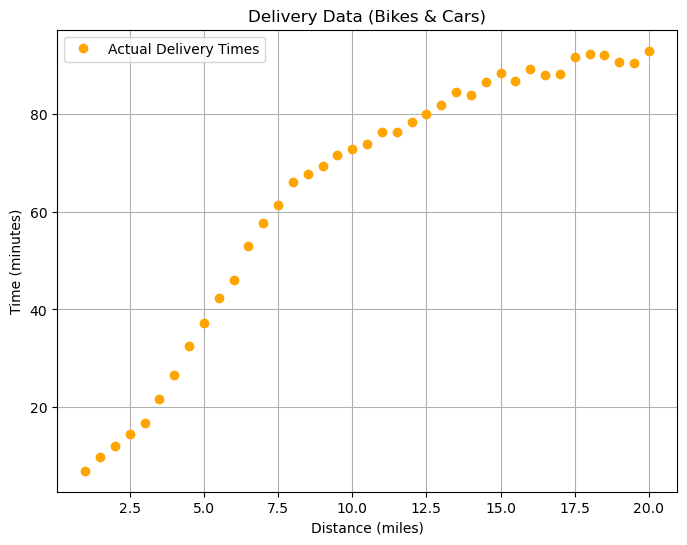

In [5]:
# plot the data
helper_utils2.plot_data(distances, times)

### Normalizing Data
Normalization is a standard method to in data preparation to make the training process more stable and affective by adjusting the scale of the data. The goal of normalizing data is to prevent large distances values from dominating the learning process and keeps gradients stable during training.

What to do in normalization?
1) Calculate mean and std for distance and times tensors
2) Apply standardization to each tensor using its respective mean and std which creates new normalized tensors named `distances_norm` and `times_norm`.

This technique of normalizing data is called standardization or z-score normalization which onverts the original data from `1.0` to `20.0` miles and approximately `7` to `93` minutes into a new, normalized scale. 

In [7]:
# Calculate the mean and std for 'distances' tensor 
distances_mean = distances.mean()
distances_std = distances.std()

# Calculate the mean and std for 'times' tensor 
times_mean = times.mean()
times_std = times.std()

# Apply normalization to the distances
distances_norm = (distances - distances_mean) / distances_std

# Appply standardization to the times
times_norm = (times - times_mean) / times_std

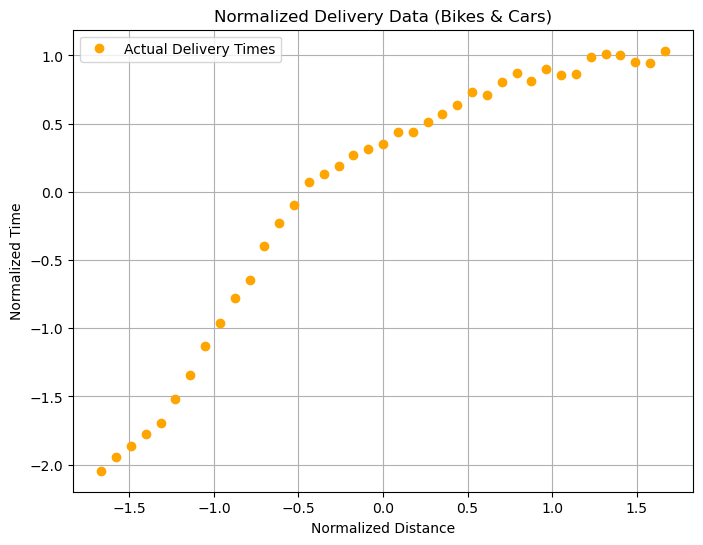

In [8]:
helper_utils2.plot_data(distances_norm, times_norm, normalize=True)

Two things to notice:
1) New data, the normalized scale with distance ranging from `-1.7` to `1.7` and time from `-2.0` to `1.0`.
2) Despite the change in scale, the underlying curved pattern of the data remains exactly the same.

## Building the Non-Linear Model
Once we have normalized data, we can now build model capable of learning curved pattern. I will use `ReLu` to help to model learns the non-linear relationship.

- `nn.Linear(1, 3)`, the hidden layer which consists of three neurons, each wull receiving one input feature (the normalized distance). This layer transforms single input into three separate values. 
- `nn.ReLu` applies ReLu activation function to the output of each of the three neurons from the hidden layer. This allows the model to crate "bends" and learn curves instead of just straight lines.
- `nn.Linear(3, 1)` is the output layer. It takes three activated values from the previous step as its input and combines them to produce a single final output, the predicted (normalized) delivery time.

This will creates a neural network with one hidden layer containing 3 neurons.

In [9]:
torch.manual_seed(27) # Ensures that the result are reproducible and consistent every time.

model = nn.Sequential(
    nn.Linear(1, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)

### Training
In this step, I define loss function and optimizer for training

In [11]:
# Define loss function and optimizer 
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

The model and training tools are now ready and I can start the training process.

1) I will run the training loop for 3000 epochs. The reason of this high loops is that non-linear relationship is more complex that we need more training. This process will repeatedly feed the normaized data to our model, measure the error and asjust the model's parameters to improve its pred.
2) The code also includes the live plot allowing us to watch in real time as our model's prediction line adapts to fit the curve data. The live plot helps us to see how our model gradually learns to fit the curve, starting with a poor fit improving over time.

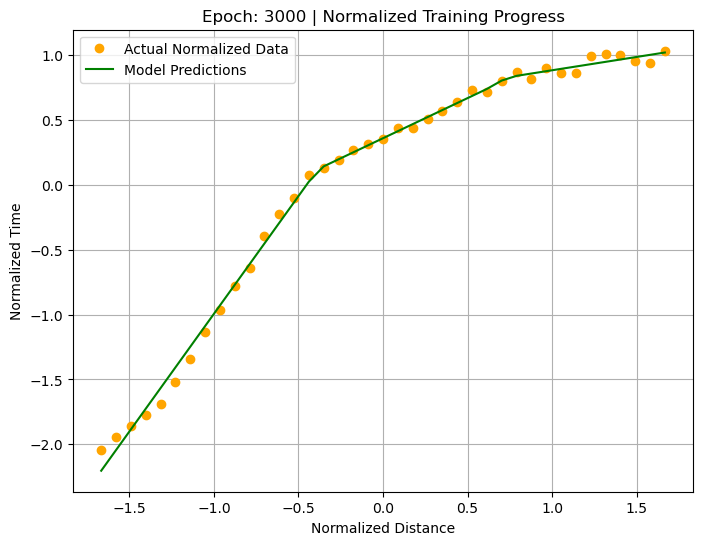


Training Complete.
Final Loss: 0.002955932868644595


In [15]:
for epoch in range(3000):
    # Reset optimizer gradient
    optimizer.zero_grad()

    # Make pred 
    outputs = model(distances_norm)

    # Calculate the loss
    loss = loss_function(outputs, times_norm)

    # calculate adjusment
    loss.backward()

    # Update model's parameters
    optimizer.step()

    # live plot for every 50 epoch
    if (epoch + 1) % 50 == 0:
        helper_utils2.plot_training_progress(
            epoch=epoch,
            loss=loss,
            model=model,
            distances_norm=distances_norm,
            times_norm=times_norm
        )

print("\nTraining Complete.")
print(f"Final Loss: {loss.item()}")

The training is now complete  and I will plot the model's final predicted curve against the original data points. This will let us visually inspect how well our linear model learned to fit the complex data pattern.

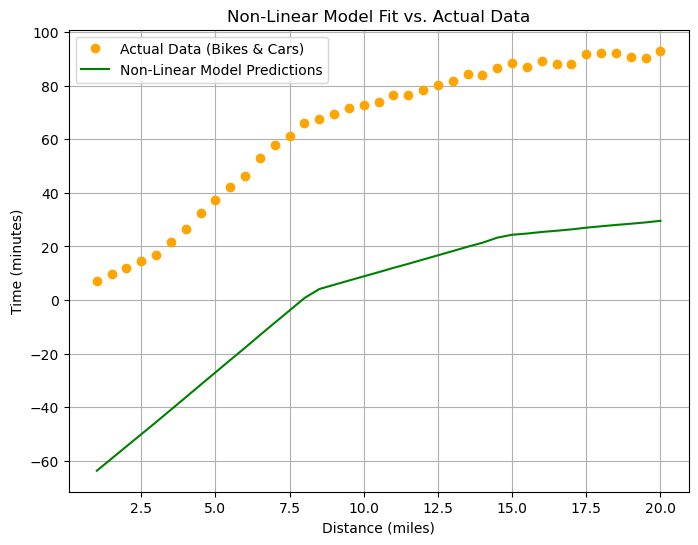

In [17]:
helper_utils2.plot_final_fit(model, distances, times, distances_norm, times_std, times_norm)

## Making Prediction
With our fully trained non-linear model, we can now use it to make a prediction for a new delivery. The process is slightly different now because our model was trained on normalized data.

1) I will take the new input distance and normalize it using the same mean and std from the training data.
2) After the model provides its prediction, we must de-normalize the output. This process will converts the prediction from its normalized scale back into an understandable value in minutes.
3) The code uses this actual predicted time to run the decision logic.

In [20]:
distance_to_predict = 5.1

In [21]:
# toch.grad() context manager for efficient prediction
with torch.no_grad():
    # Normalize the input distance 
    distance_tensor = torch.tensor([[distance_to_predict]], dtype=torch.float32)
    new_distance_norm = (distance_tensor - distances_mean) / distances_std

    # Get the normalized pred from the model
    predicted_time_norm = model(new_distance_norm)

    # De-normalize the output to get actual time in minutes
    predicted_time_actual = (predicted_time_norm * times_std) + times_mean

    # Decision making logic 
    print(f"Prediction for a {distance_to_predict}-mile delivery: {predicted_time_actual.item():.1f} minutes")

    # First, check if the delivery is possible within the 45 minutes timeframe
    if predicted_time_actual.item() > 45:
        print("\nDecision: Do NOT promise the delivery in under 45 minutes.")
    else:
        # If it possible, then determine the vehicle based on the distance
        if distance_to_predict <= 3:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (<= 3 miles), use a bike.")
        else:
            print(f"\nDecision: Yes, delivery is possible. Since the distance is {distance_to_predict} miles (> 3 miles), use a car.")
            

Prediction for a 5.1-mile delivery: 39.0 minutes

Decision: Yes, delivery is possible. Since the distance is 5.1 miles (> 3 miles), use a car.


## Conclusion 
- Adding activation function, `ReLu` gives the model ability to succeed where the linear model had failed.
- The model can capture complex, curved patterns.
- Normalization helps the training process more stable and effective.